In [1]:
### Decide about the features to take according to the submission file

import pandas as pd
import numpy as np
data1 = pd.read_table('submission.txt')

In [2]:
import time
data1['time'] = data1['DATE'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S.000'))
data1['day_week'] = data1['time'].apply(lambda x: time.strftime("%w", x))
data1['month'] = data1['time'].apply(lambda x: time.strftime("%m", x))

In [3]:
### New features: dummies for the day of the week, ASS_ASSIGNMENT, months

data1 = pd.concat((data1, pd.get_dummies(data1['day_week'])),axis=1)
data1 = pd.concat((data1, pd.get_dummies(data1['ASS_ASSIGNMENT'])),axis=1)
data1 = pd.concat((data1, pd.get_dummies(data1['month'])),axis=1)


In [4]:
### New feature: hours since the start of the day

data1['time_absolut'] = data1['time'].apply(time.mktime) ### date scince epoch
data1['hours'] = data1['time'].apply(lambda x: float(time.strftime("%H", x))+np.sign(float(time.strftime("%M", x)))*0.5)

In [6]:
indexes = np.concatenate((data1.day_week.unique(), data1.ASS_ASSIGNMENT.unique()))
#indexes = np.concatenate((indexes, data.month.unique()))
indexes = np.concatenate((indexes, data1.ASS_ASSIGNMENT.unique()))
indexes = np.concatenate((indexes, ['hours']))
indexes = np.concatenate((indexes, ['mean_calls_time_ASS','mean_calls_time']))

In [7]:
### Test data processing

M=100000
#data = pd.read_csv('train_2011_2012_2013.csv',delimiter=';',usecols=['DATE','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS'], nrows=M)
data = pd.read_csv('train_2011_2012_2013.csv',delimiter=';',usecols=['DATE','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS'])

In [8]:
d = pd.DataFrame(data.groupby(['DATE', 'ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].sum())
d.reset_index(level=0, inplace=True)
d.reset_index(level=0, inplace=True)
data = d

In [9]:
import time
data['time'] = data['DATE'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S.000'))
data['day_week'] = data['time'].apply(lambda x: time.strftime("%w", x))
data['month'] = data['time'].apply(lambda x: time.strftime("%m", x))

In [10]:
#data['ASS_ASSIGNMENT'].value_counts()

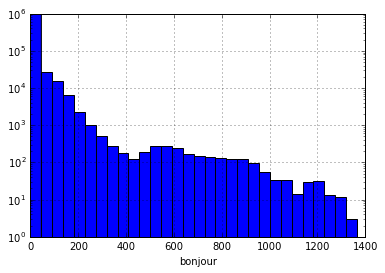

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.yscale('log')
data['CSPL_RECEIVED_CALLS'].hist(bins=30)
plt.xlabel('bonjour')

In [12]:
### New features: dummies for the day of the week, ASS_ASSIGNMENT, months

data = pd.concat((data, pd.get_dummies(data['day_week'])),axis=1)
data = pd.concat((data, pd.get_dummies(data['ASS_ASSIGNMENT'])),axis=1)
data = pd.concat((data, pd.get_dummies(data['month'])),axis=1)

In [13]:
### New feature: hours since the start of the day
data['hours'] = data['time'].apply(lambda x: float(time.strftime("%H", x))+np.sign(float(time.strftime("%M", x)))*0.5)

In [14]:
### date scince epoch
data['time_absolut'] = data['time'].apply(time.mktime)

In [15]:
time.gmtime(data['time_absolut'].max())

time.struct_time(tm_year=2013, tm_mon=12, tm_mday=31, tm_hour=22, tm_min=30, tm_sec=0, tm_wday=1, tm_yday=365, tm_isdst=0)

In [16]:
time.gmtime(data['time_absolut'].min())

time.struct_time(tm_year=2010, tm_mon=12, tm_mday=31, tm_hour=23, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=365, tm_isdst=0)

In [17]:
### New feature: average number of calls during h hours before the time for the specific category

#def get_window1(x, h):
#    interval = h*3600
#    tmp = data_res[data_res['ASS_ASSIGNMENT'] == x['ASS_ASSIGNMENT']]
#    tmp = tmp[tmp['time_absolut'] >= x['time_absolut']-interval] 
#    tmp = tmp[tmp['time_absolut'] < x['time_absolut']]
#    return tmp['CSPL_RECEIVED_CALLS'].mean()

#data['mean_calls_24h_past_time'] = data[['time_absolut','ASS_ASSIGNMENT']].apply(lambda p: get_window1(p, 24),axis=1)

In [18]:
### New feature: average over all the dates for the specific category and time

d1 = pd.DataFrame(data.groupby(['hours', 'ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].mean())

mean_calls_time_ASS_res = d1

d1.reset_index(level=0, inplace=True)
d1.reset_index(level=0, inplace=True)
data = d1.merge(data,on=['hours','ASS_ASSIGNMENT'])
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_x' : 'mean_calls_time_ASS'})
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_y' : 'CSPL_RECEIVED_CALLS'})

In [19]:
### New feature: average over all the dates for the specific time

d2 = pd.DataFrame(data.groupby(['hours'])['CSPL_RECEIVED_CALLS'].mean())

mean_calls_time_res = d2

d2.reset_index(level=0, inplace=True)
d2.reset_index(level=0, inplace=True)
data = d2.merge(data,on=['hours'])
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_x' : 'mean_calls_time'})
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_y' : 'CSPL_RECEIVED_CALLS'})

In [20]:
indexes

array(['5', '6', '0', '1', '2', '3', '4', 'CMS', 'Crises', 'Domicile',
       'Gestion', 'Gestion - Accueil Telephonique', 'Gestion Assurances',
       'Gestion Relation Clienteles', 'Gestion Renault', 'Japon',
       'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale', 'SAP',
       'Services', 'Tech. Axa', 'Tech. Inter', 'Téléphonie', 'Tech. Total',
       'Mécanicien', 'CAT', 'Manager', 'Gestion Clients', 'Gestion DZ',
       'RTC', 'Prestataires', 'CMS', 'Crises', 'Domicile', 'Gestion',
       'Gestion - Accueil Telephonique', 'Gestion Assurances',
       'Gestion Relation Clienteles', 'Gestion Renault', 'Japon',
       'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale', 'SAP',
       'Services', 'Tech. Axa', 'Tech. Inter', 'Téléphonie', 'Tech. Total',
       'Mécanicien', 'CAT', 'Manager', 'Gestion Clients', 'Gestion DZ',
       'RTC', 'Prestataires', 'hours', 'mean_calls_time_ASS',
       'mean_calls_time'], dtype=object)

In [21]:
### Algorithmic part

from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.cross_validation import train_test_split

X = data[indexes]

In [22]:
Y = data['CSPL_RECEIVED_CALLS']
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [23]:
model = rf()
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [24]:
pred = np.round(pred)

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r2_score(y_test, pred)
#mean_squared_error(y_test, pred)

0.48650454305507895

In [26]:
#y_test

In [1106]:
#data1 = pd.read_table('submission.txt')

In [1107]:
#import time
#data1['time'] = data1['DATE'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S.000'))
#data1['day_week'] = data1['time'].apply(lambda x: time.strftime("%w", x))
#data1['month'] = data1['time'].apply(lambda x: time.strftime("%m", x))

In [1108]:
#data1 = pd.concat((data1, pd.get_dummies(data1['day_week'])),axis=1)
#data1 = pd.concat((data1, pd.get_dummies(data1['ASS_ASSIGNMENT'])),axis=1)
#data1 = pd.concat((data1, pd.get_dummies(data1['month'])),axis=1)

In [1109]:
### New feature: hours since the start of the day

#data1['hours'] = data1['time'].apply(lambda x: float(time.strftime("%H", x))+np.sign(float(time.strftime("%M", x)))*0.5)

In [28]:
data1 = mean_calls_time_res.merge(data1,on=['hours'])
data1['mean_calls_time']=data1['CSPL_RECEIVED_CALLS']

In [29]:
data1 = mean_calls_time_ASS_res.merge(data1,on=['hours','ASS_ASSIGNMENT'])

In [30]:
data1['mean_calls_time_ASS'] = data1['CSPL_RECEIVED_CALLS_x']

In [31]:
X = data1[indexes]

In [32]:
pred = np.round(model.predict(X))

In [33]:
d = pd.DataFrame(pred, columns=['prediction'])
data1['prediction'] = d['prediction']

In [34]:
data1 = data1.sort_values('time') 

In [35]:
base_filename = 'submission1.txt'
data1[['DATE','ASS_ASSIGNMENT','prediction']].to_csv(base_filename, sep=' ', index=False)